In [1]:
import pandas as pd
import numpy as np
import yaml
import sys
import warnings

import plotter as plot
import matplotlib.pyplot as plt

from pathlib import Path

from Stocks import Stock
from Portfolio import Portfolio
import distributions as dt
import returns as rt
import financial_ratios as fr
import optimizers as opt
import numpy as np
import prophet_helpers as ph
import timestamps as ts
import seaborn as sns


import scipy.stats as stats
from prophet import Prophet


warnings.simplefilter(action='ignore')

def read_yaml(file_name): 
    with open(file_name) as file:
        yaml_data= yaml.safe_load(file)
    return yaml_data

config = read_yaml('config.yaml')
# config['canadian_etfs_parsed']
canadian_etfs_parsed = config['canadian_etfs_parsed']
canadian_etfs_parsed



['VFV.TO']

<img src="Dataset_info.png" alt="Screenshot" width="800" height='400'/>

# Data Loading 

In [2]:
start_dt = '2011-01-03'
end_dt= '2015-04-13'
training_start_dt = '2011-01-03'
training_end_dt = '2012-12-31'

test_start_dt = '2013-01-02' 
test_end_dt = '2013-12-31'

out_of_sample_start_dt = '2014-01-02'
out_of_sample_end_dt = '2015-04-13'

dia_df = Stock('DIA', start_dt, end_dt)
# dia_df.ticker_data['ticker'] = 'diaA'

spy_df= Stock('SPY',start_dt, end_dt)
# spy_df.ticker_data['ticker'] = 'SPY'

qqq_df = Stock('QQQ', start_dt, end_dt)
# qqq_df.ticker_data['ticker'] = 'QQQ'

data from alpaca
Data from alpaca not available, pulling from yahoo
[*********************100%***********************]  1 of 1 completed
data from alpaca
Data from alpaca not available, pulling from yahoo
[*********************100%***********************]  1 of 1 completed
data from alpaca
Data from alpaca not available, pulling from yahoo
[*********************100%***********************]  1 of 1 completed


In [3]:
dia_df.ticker_data.head()

Open        High         Low       Close   Volume ticker  \
2011-01-03  116.410004  116.860001  116.360001  116.410004  9108900    DIA   
2011-01-04  116.709999  116.730003  116.110001  116.639999  9775600    DIA   
2011-01-05  116.459999  117.190002  116.300003  117.040001  7567800    DIA   
2011-01-06  117.139999  117.190002  116.500000  116.779999  7161600    DIA   
2011-01-07  116.910004  117.099998  115.820000  116.570000  9249800    DIA   

            pct_change  Cumulative_Percentage_Change  normalized_close  \
2011-01-03         NaN                      0.000000          0.131682   
2011-01-04    0.001976                      0.197574          0.134696   
2011-01-05    0.003429                      0.541188          0.139937   
2011-01-06   -0.002221                      0.317838          0.136530   
2011-01-07   -0.001798                      0.137442          0.133779   

            cumulative_mean_normalized_close  \
2011-01-03                          0.131682   
2011-01-04                          0.133189   
2011-01-05                          0.135439   
2011-01-06                          0.135711   
2011-01-07                          0.135325   

            cumulative_variance_normalized_close  \
2011-01-03                              0.000000   
2011-01-04                              0.000002   
2011-01-05                              0.000012   
2011-01-06                              0.000009   
2011-01-07                              0.000008   

            cumulative_std_normalized_close      skew  kurtosis  \
2011-01-03                         0.000000 -0.426358  4.152463   
2011-01-04                         0.001507 -0.426358  4.152463   
2011-01-05                         0.003411 -0.426358  4.152463   
2011-01-06                         0.002991 -0.426358  4.152463   
2011-01-07                         0.002785 -0.426358  4.152463   

            Jarque_Bera_stat  Jarque_Bera_p_val  
2011-01-03        804.160704      2.391784e-175  
2011-01-04        804.160704      2.391784e-175  
2011-01-05        804.160704      2.391784e-175  
2011-01-06        804.160704      2.391784e-175  
2011-01-07        804.160704      2.391784e-175

# Portfolio Creation and Summary Statistics

In [4]:
p = Portfolio(tickers=[ 'DIA', 'QQQ', 'SPY' ], start_dt=start_dt, end_dt=end_dt)
cm = sns.light_palette("green", as_cmap=True) 
p.summary_statistics.style.background_gradient(cmap=cm)

data from alpaca
Data from alpaca not available, pulling from yahoo
[*********************100%***********************]  1 of 1 completed
data from alpaca
Data from alpaca not available, pulling from yahoo
[*********************100%***********************]  1 of 1 completed
data from alpaca
Data from alpaca not available, pulling from yahoo
[*********************100%***********************]  1 of 1 completed


In [5]:
p.correlation_matrix.style.background_gradient(cmap=cm)

In [6]:
df = p.all_stocks_df.copy(deep=True)
df.head()

Open        High         Low       Close   Volume ticker  \
2011-01-03  116.410004  116.860001  116.360001  116.410004  9108900    DIA   
2011-01-04  116.709999  116.730003  116.110001  116.639999  9775600    DIA   
2011-01-05  116.459999  117.190002  116.300003  117.040001  7567800    DIA   
2011-01-06  117.139999  117.190002  116.500000  116.779999  7161600    DIA   
2011-01-07  116.910004  117.099998  115.820000  116.570000  9249800    DIA   

            pct_change  Cumulative_Percentage_Change  normalized_close  \
2011-01-03         NaN                      0.000000          0.131682   
2011-01-04    0.001976                      0.197574          0.134696   
2011-01-05    0.003429                      0.541188          0.139937   
2011-01-06   -0.002221                      0.317838          0.136530   
2011-01-07   -0.001798                      0.137442          0.133779   

            cumulative_mean_normalized_close  \
2011-01-03                          0.131682   
2011-01-04                          0.133189   
2011-01-05                          0.135439   
2011-01-06                          0.135711   
2011-01-07                          0.135325   

            cumulative_variance_normalized_close  \
2011-01-03                              0.000000   
2011-01-04                              0.000002   
2011-01-05                              0.000012   
2011-01-06                              0.000009   
2011-01-07                              0.000008   

            cumulative_std_normalized_close      skew  kurtosis  \
2011-01-03                         0.000000 -0.426358  4.152463   
2011-01-04                         0.001507 -0.426358  4.152463   
2011-01-05                         0.003411 -0.426358  4.152463   
2011-01-06                         0.002991 -0.426358  4.152463   
2011-01-07                         0.002785 -0.426358  4.152463   

            Jarque_Bera_stat  Jarque_Bera_p_val  
2011-01-03        804.160704      2.391784e-175  
2011-01-04        804.160704      2.391784e-175  
2011-01-05        804.160704      2.391784e-175  
2011-01-06        804.160704      2.391784e-175  
2011-01-07        804.160704      2.391784e-175

# EDA Plots on Portfolio

### Plotting Closing Price across all items in Portfolio

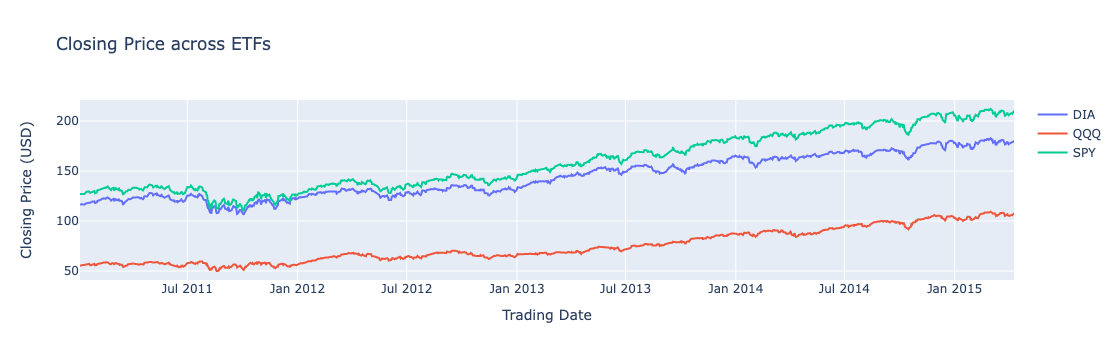

In [7]:
plot.plot_column_across_tickers(df, col_name = 'Close', title='Closing Price across ETFs', yaxis_title='Closing Price (USD)', xaxis_title='Trading Date')

### Plotting Normalized Closing Price across all items in Portfolio

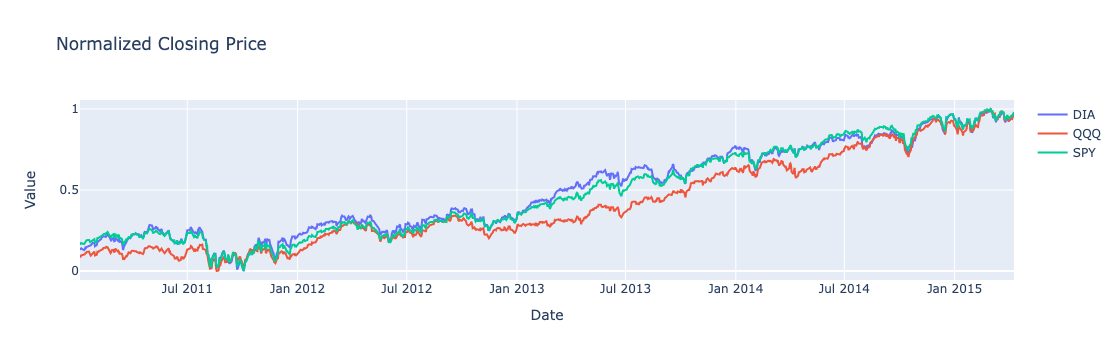

In [8]:
plot.plot_column_across_tickers(df, col_name = 'normalized_close', title='Normalized Closing Price')

### Plotting Cumulative Returns across all items in Portfolio

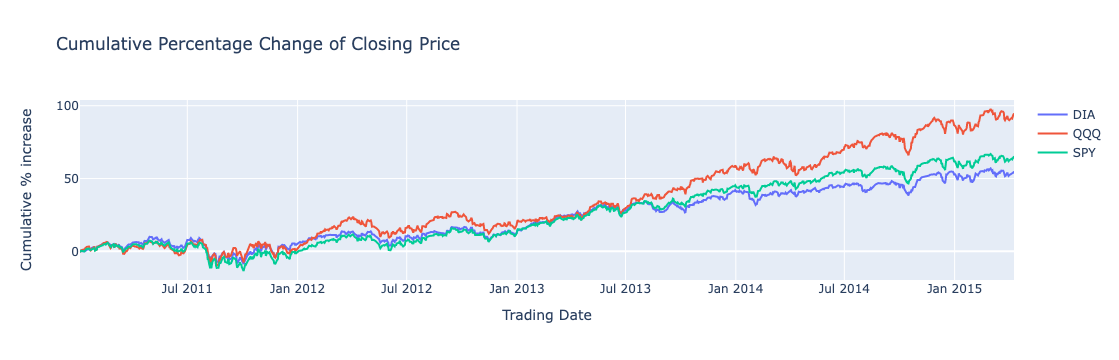

In [9]:
plot.plot_column_across_tickers(df, col_name = 'Cumulative_Percentage_Change', title='Cumulative Percentage Change of Closing Price', xaxis_title='Trading Date', yaxis_title='Cumulative % increase')

### Cumulative Returns of Normalized Closing Price

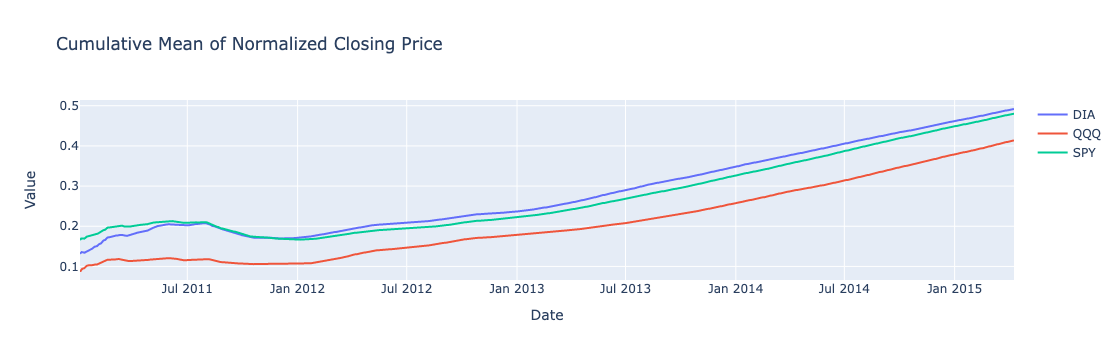

In [10]:
plot.plot_column_across_tickers(df, col_name = 'cumulative_mean_normalized_close', title='Cumulative Mean of Normalized Closing Price')

### Plotting Cumulative Variance of Normalized Closing Price

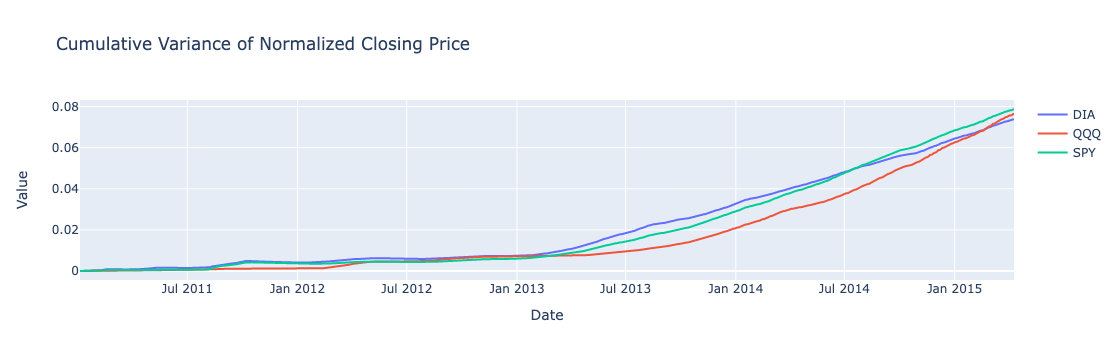

In [11]:
plot.plot_column_across_tickers(df, col_name = 'cumulative_variance_normalized_close', title='Cumulative Variance of Normalized Closing Price')

### Plotting Cumulative Variance of Normalized Closing Price

plot.plot_column_across_tickers(df, col_name = 'cumulative_std_normalized_close', title='Cumulative Standard Deviation of Normalized Closing Price')

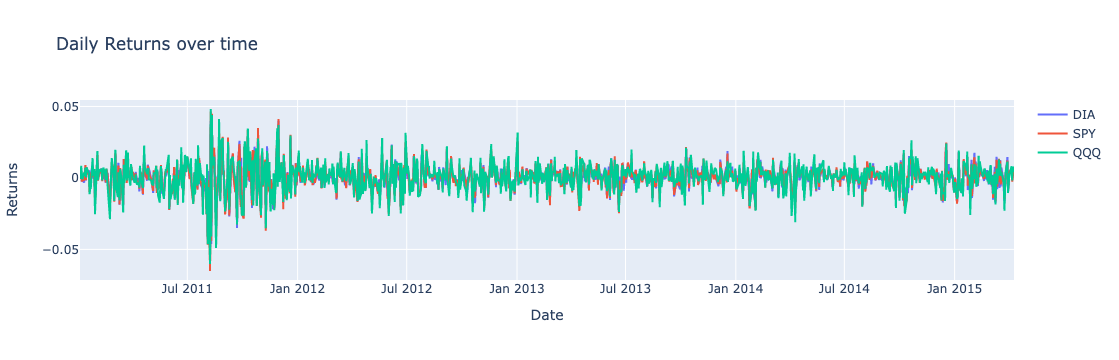

In [13]:
x_data = [list(dia_df.ticker_data.index),list(spy_df.ticker_data.index),list(qqq_df.ticker_data.index)]
y_data = [list(dia_df.ticker_data['pct_change']), list(spy_df.ticker_data['pct_change']), list(qqq_df.ticker_data['pct_change'])]

plot.plot_multi_line_chart(x_data, y_data, labels=['DIA', 'SPY', 'QQQ'], title='Daily Returns over time', xaxis_title='Date', yaxis_title='Returns')

# Normality Tests

### PDF Plots

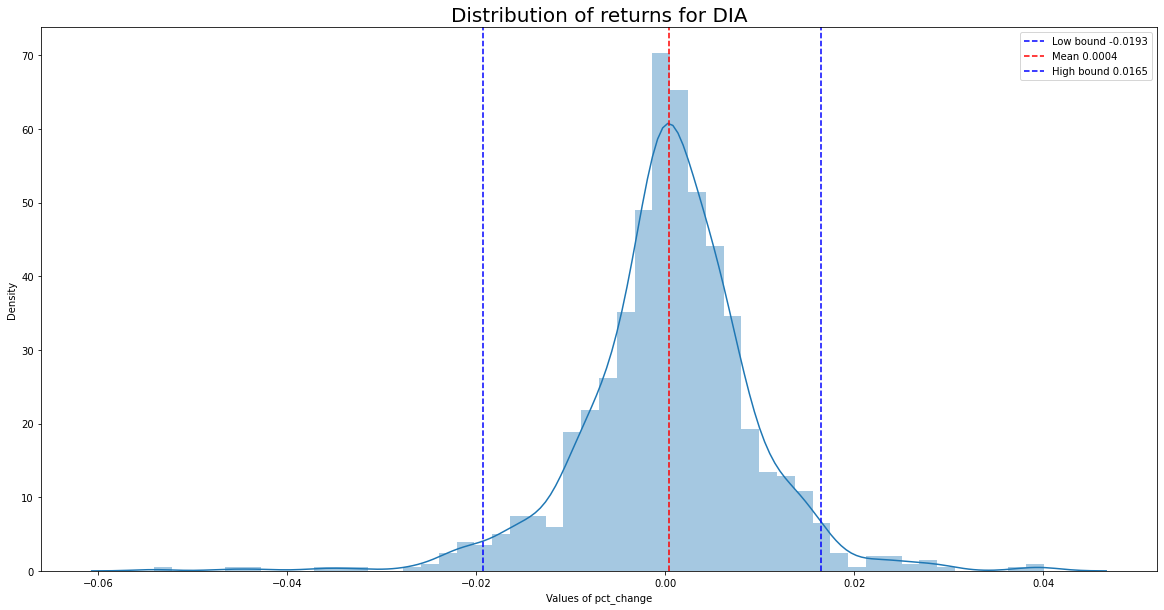

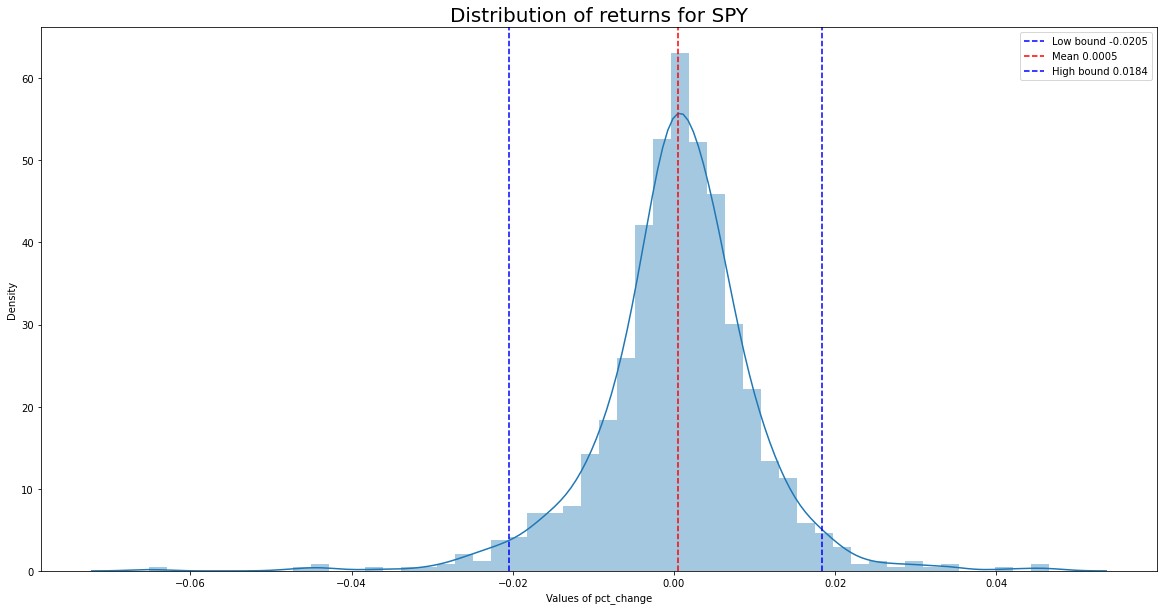

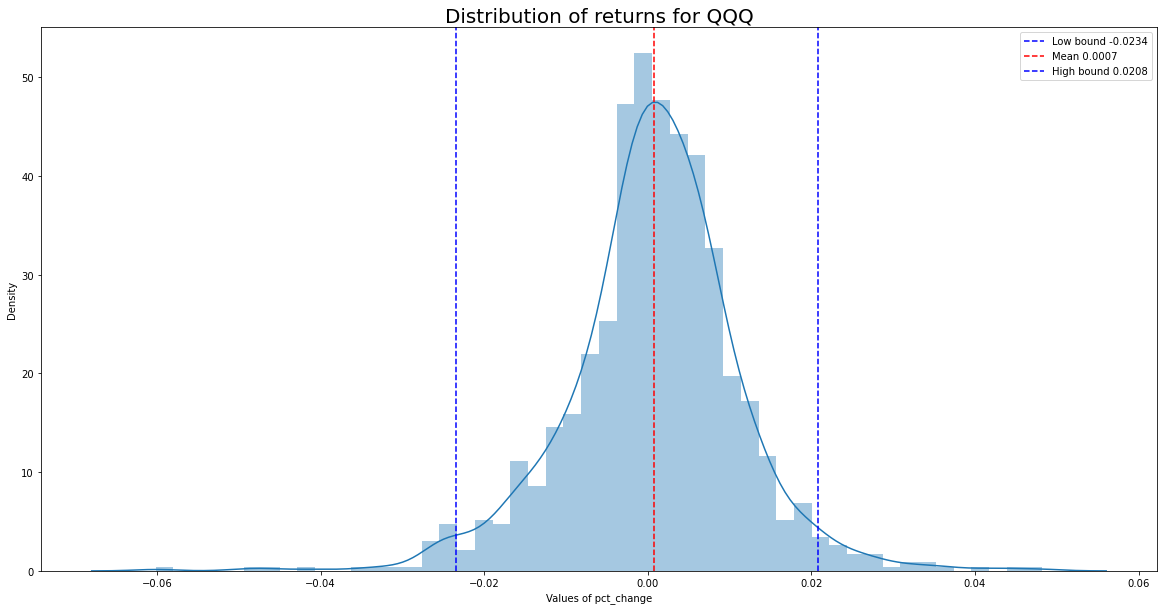

(-0.023438803232610717, 0.000677142553587241, 0.02076793119111553)

In [52]:
low_bound, mean, high_bound = dt.get_confidence_interval(dia_df.ticker_data, 'pct_change',title= 'Distribution of returns for DIA', conf_interval=95)
low_bound, mean, high_bound = dt.get_confidence_interval(spy_df.ticker_data, 'pct_change', title='Distribution of returns for SPY',conf_interval=95)
low_bound, mean, high_bound = dt.get_confidence_interval(qqq_df.ticker_data, 'pct_change', title='Distribution of returns for QQQ', conf_interval=95)
low_bound, mean, high_bound 

# Summary Performance Statistics for Portfolio

In [16]:
agg_stats_df = []
tickers = list(df['ticker'].unique())

for i in range(0,len(tickers)):
    temp_df = df[df['ticker']==tickers[i]]
    
    

    price_data = temp_df['Close']
    returns = (price_data / price_data.shift(1)) - 1
    returns = returns.iloc[1:]
    
    VaR = rt.historical_var(returns, confidence_level=0.95)
    cVaR = rt.historical_cvar(returns, confidence_level=0.95)
    sharpe_ratio = fr.get_sharpe_ratio(returns, risk_free_rate=0.02)
    sortino_ratio = fr.get_sortino_ratio(returns, risk_free_rate=0.02)
    
    
    print(f"Historical VaR :{VaR}")
    print(f"Historical cVaR :{cVaR}")

    agg_stats_df.append(pd.DataFrame({'ticker':[tickers[i]], 'mean':[temp_df['normalized_close'].mean()], 'std_dev':[temp_df['normalized_close'].std()], \
                                     'VaR':[VaR], 'cVaR':[cVaR], 'sharpe_ratio':[sharpe_ratio], 'sortino_ratio':[sortino_ratio]}))
    
agg_stats_df = pd.concat(agg_stats_df)
agg_stats_df.reset_index().style.background_gradient(cmap=cm)



Historical VaR :0.014497983135277897
Historical cVaR :0.02126555571682207
Historical VaR :0.01683519001841196
Historical cVaR :0.0244655884183221
Historical VaR :0.015868511657855144
Historical cVaR :0.023026228323637512


# Portfolio Simulations

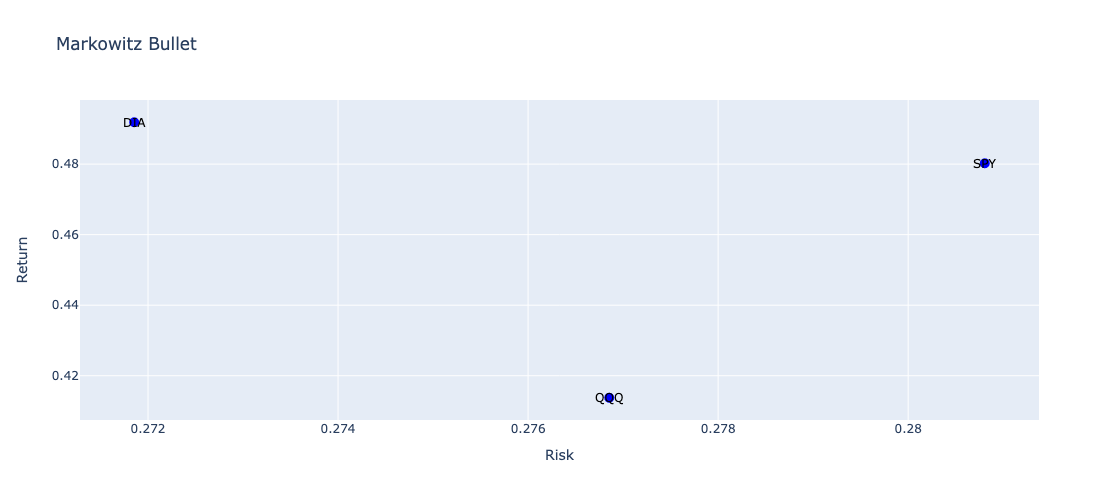

In [17]:
plot.plot_markowitz_bullet(list(agg_stats_df['std_dev']), list(agg_stats_df['mean']), text_vals =list(agg_stats_df['ticker']),  title='Markowitz Bullet', xaxis_title='Risk', yaxis_title='Return')

### Mean-VaR plot

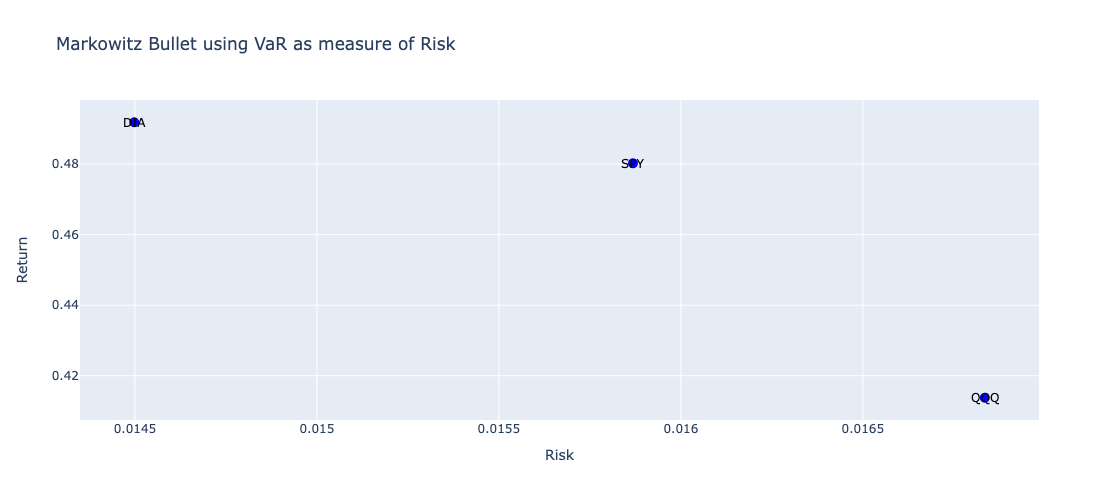

In [18]:
plot.plot_markowitz_bullet(list(agg_stats_df['VaR']), list(agg_stats_df['mean']), text_vals =list(agg_stats_df['ticker']),  title='Markowitz Bullet using VaR as measure of Risk', xaxis_title='Risk', yaxis_title='Return')


### Mean - cVaR plot

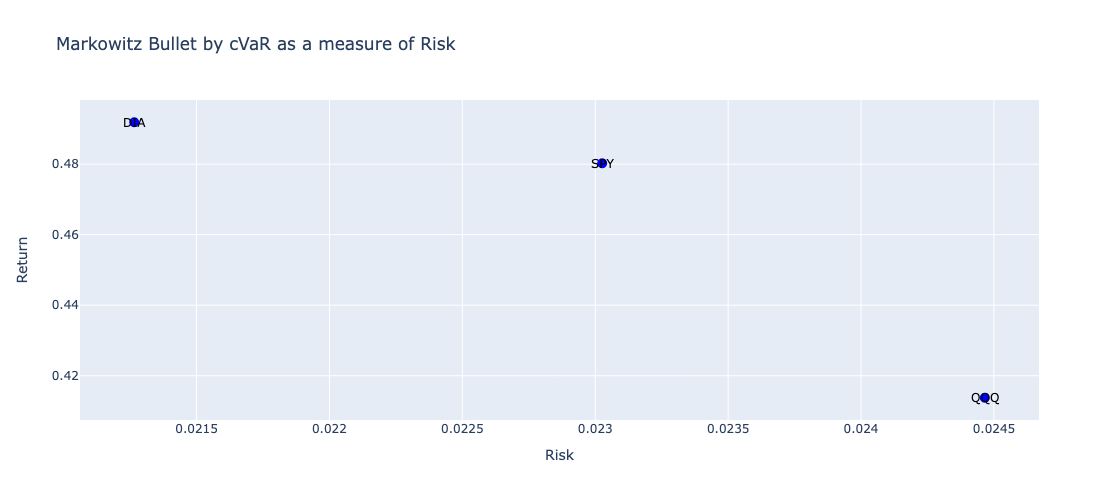

In [19]:
plot.plot_markowitz_bullet(list(agg_stats_df['cVaR']), list(agg_stats_df['mean']), text_vals =list(agg_stats_df['ticker']),  title='Markowitz Bullet by cVaR as a measure of Risk', xaxis_title='Risk', yaxis_title='Return')

### QQ Plots

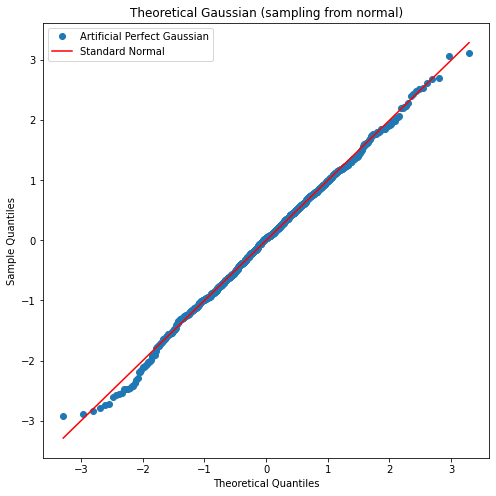

<Figure size 432x288 with 0 Axes>

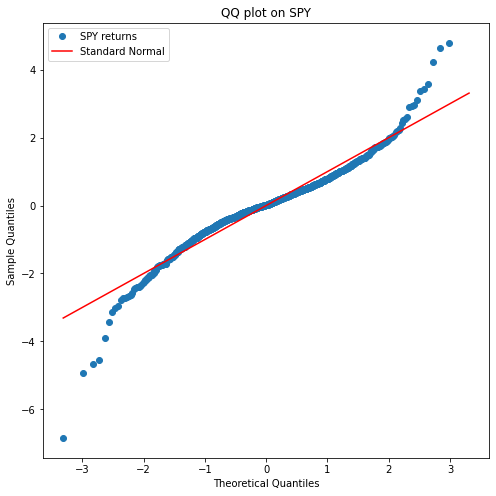

<Figure size 432x288 with 0 Axes>

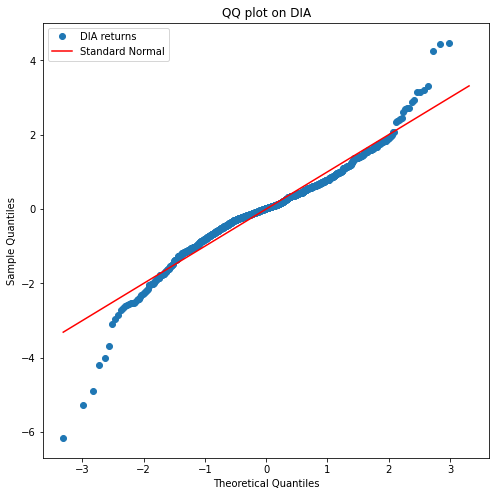

<Figure size 432x288 with 0 Axes>

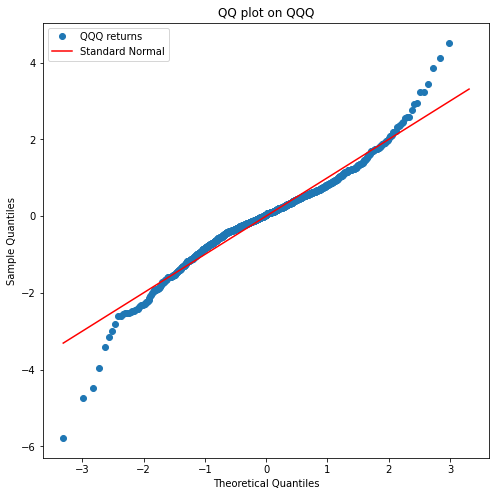

<Figure size 432x288 with 0 Axes>

In [23]:
data = np.random.normal(0, 1, 1000)  # Generate a sample normal distribution
dt.generate_qq_plot_normal(data, title='Theoretical Gaussian (sampling from normal)', label='Artificial Perfect Gaussian')

dt.generate_qq_plot_normal(spy_df.ticker_data['pct_change'], title='QQ plot on SPY', label='SPY returns')
dt.generate_qq_plot_normal(dia_df.ticker_data['pct_change'], title='QQ plot on DIA', label='DIA returns')
dt.generate_qq_plot_normal(qqq_df.ticker_data['pct_change'], title='QQ plot on QQQ', label='QQQ returns')

In [24]:
dia_df = Stock('DIA', start_dt, end_dt)
# dia_df.ticker_data['ticker'] = 'diaA'

spy_df= Stock('SPY', start_dt, end_dt)
# spy_df.ticker_data['ticker'] = 'SPY'

qqq_df = Stock('QQQ', start_dt, end_dt)
# qqq_df.ticker_data['ticker'] = 'QQQ'

data from alpaca
Data from alpaca not available, pulling from yahoo
[*********************100%***********************]  1 of 1 completed
data from alpaca
Data from alpaca not available, pulling from yahoo
[*********************100%***********************]  1 of 1 completed
data from alpaca
Data from alpaca not available, pulling from yahoo
[*********************100%***********************]  1 of 1 completed


In [25]:
dfs = [dia_df.ticker_data,spy_df.ticker_data, qqq_df.ticker_data]

def merge_dfs(dfs): 

    merged_df = dfs[0].copy(deep=True)
    ticker = merged_df['ticker'].iloc[0]
    merged_df.rename(columns={'Close':f'Close_{ticker}'}, inplace=True)

    for i in range(1,len(dfs)): 
        temp_df =dfs[i].copy(deep=True)
        temp_ticker = temp_df['ticker'].iloc[0]
        temp_df.rename(columns={'Close':f'Close_{temp_ticker}'}, inplace=True)


        merged_df = pd.merge(merged_df, temp_df, left_index=True, right_index=True)
        
    return merged_df 
    
merged_df =merge_dfs(dfs)
merged_df.head()

Open_x      High_x       Low_x   Close_DIA  Volume_x ticker_x  \
2011-01-03  116.410004  116.860001  116.360001  116.410004   9108900      DIA   
2011-01-04  116.709999  116.730003  116.110001  116.639999   9775600      DIA   
2011-01-05  116.459999  117.190002  116.300003  117.040001   7567800      DIA   
2011-01-06  117.139999  117.190002  116.500000  116.779999   7161600      DIA   
2011-01-07  116.910004  117.099998  115.820000  116.570000   9249800      DIA   

            pct_change_x  Cumulative_Percentage_Change_x  normalized_close_x  \
2011-01-03           NaN                        0.000000            0.131682   
2011-01-04      0.001976                        0.197574            0.134696   
2011-01-05      0.003429                        0.541188            0.139937   
2011-01-06     -0.002221                        0.317838            0.136530   
2011-01-07     -0.001798                        0.137442            0.133779   

            cumulative_mean_normalized_close_x  ...  pct_change  \
2011-01-03                            0.131682  ...         NaN   
2011-01-04                            0.133189  ...   -0.000723   
2011-01-05                            0.135439  ...    0.008504   
2011-01-06                            0.135711  ...    0.003229   
2011-01-07                            0.135325  ...   -0.000894   

            Cumulative_Percentage_Change  normalized_close  \
2011-01-03                      0.000000          0.088964   
2011-01-04                     -0.072321          0.088290   
2011-01-05                      0.777437          0.096209   
2011-01-06                      1.102869          0.099242   
2011-01-07                      1.012471          0.098399   

            cumulative_mean_normalized_close  \
2011-01-03                          0.088964   
2011-01-04                          0.088627   
2011-01-05                          0.091154   
2011-01-06                          0.093176   
2011-01-07                          0.094221   

            cumulative_variance_normalized_close  \
2011-01-03                          0.000000e+00   
2011-01-04                          1.135634e-07   
2011-01-05                          1.285105e-05   
2011-01-06                          2.190242e-05   
2011-01-07                          2.188707e-05   

            cumulative_std_normalized_close      skew  kurtosis  \
2011-01-03                         0.000000 -0.319222  3.023044   
2011-01-04                         0.000337 -0.319222  3.023044   
2011-01-05                         0.003585 -0.319222  3.023044   
2011-01-06                         0.004680 -0.319222  3.023044   
2011-01-07                         0.004678 -0.319222  3.023044   

            Jarque_Bera_stat  Jarque_Bera_p_val  
2011-01-03        427.201569       1.715371e-93  
2011-01-04        427.201569       1.715371e-93  
2011-01-05        427.201569       1.715371e-93  
2011-01-06        427.201569       1.715371e-93  
2011-01-07        427.201569       1.715371e-93  

[5 rows x 48 columns]

In [26]:
irrelevant_cols = [col for col in merged_df.columns if any(x in col.lower() for x in ['open', 'high', 'low', 'volume'])]
irrelevant_cols

merged_df.drop(columns=irrelevant_cols, inplace=True)
close_cols = [f'Close_{ticker}' for ticker in tickers]
close_cols

['Close_DIA', 'Close_QQQ', 'Close_SPY']

In [27]:
merged_df = merged_df[close_cols]
merged_df.head()

Close_DIA  Close_QQQ   Close_SPY
2011-01-03  116.410004  55.310001  127.050003
2011-01-04  116.639999  55.270000  126.980003
2011-01-05  117.040001  55.740002  127.639999
2011-01-06  116.779999  55.919998  127.389999
2011-01-07  116.570000  55.869999  127.139999

In [28]:
def generate_combinations(step=0.2, target_sum=1.0, num_variables=3, precision=1):
    combinations = []
    num_steps = int(target_sum / step) + 1

    for i in range(num_steps):
        for j in range(num_steps - i):
            k = num_steps - i - j - 1
            if round(i * step, precision) + round(j * step, precision) + round(k * step, precision) == target_sum:
                combinations.append((round(i * step, precision), round(j * step, precision), round(k * step, precision)))

    return combinations

combinations = generate_combinations()
print(combinations)


[(0.0, 0.0, 1.0), (0.0, 0.2, 0.8), (0.0, 0.4, 0.6), (0.0, 0.6, 0.4), (0.0, 0.8, 0.2), (0.0, 1.0, 0.0), (0.2, 0.0, 0.8), (0.2, 0.2, 0.6), (0.2, 0.4, 0.4), (0.2, 0.6, 0.2), (0.2, 0.8, 0.0), (0.4, 0.0, 0.6), (0.4, 0.2, 0.4), (0.4, 0.4, 0.2), (0.4, 0.6, 0.0), (0.6, 0.0, 0.4), (0.6, 0.2, 0.2), (0.6, 0.4, 0.0), (0.8, 0.0, 0.2), (0.8, 0.2, 0.0), (1.0, 0.0, 0.0)]


In [29]:
combinations_df = pd.DataFrame(combinations, columns=tickers)
combinations_df

DIA  QQQ  SPY
0   0.0  0.0  1.0
1   0.0  0.2  0.8
2   0.0  0.4  0.6
3   0.0  0.6  0.4
4   0.0  0.8  0.2
5   0.0  1.0  0.0
6   0.2  0.0  0.8
7   0.2  0.2  0.6
8   0.2  0.4  0.4
9   0.2  0.6  0.2
10  0.2  0.8  0.0
11  0.4  0.0  0.6
12  0.4  0.2  0.4
13  0.4  0.4  0.2
14  0.4  0.6  0.0
15  0.6  0.0  0.4
16  0.6  0.2  0.2
17  0.6  0.4  0.0
18  0.8  0.0  0.2
19  0.8  0.2  0.0
20  1.0  0.0  0.0

### Simulation of Portfolio performance under naive weights

In [30]:
initial_budget =10000

def simulate_portfolio_value(input_df, combination): 

    for i in range(0,len(combination)): 
        input_df[f'weight_{tickers[i]}'] = combination[i]

    for ticker in tickers: 
        input_df[f'{ticker}_num_stocks'] = initial_budget*input_df[f'weight_{ticker}'].iloc[0]/input_df[f'Close_{ticker}'].iloc[0]

    portfolio_values = []
    for i in range(0,len(input_df)): 
        portfolio_value = 0
        for ticker in tickers: 
            portfolio_value+= input_df[f'Close_{ticker}'].iloc[i] * input_df[f'{ticker}_num_stocks'].iloc[0]
        portfolio_values.append(portfolio_value)
    portfolio_values

    input_df['portfolio_value'] = portfolio_values

    return input_df

Text(0, 0.5, 'Portfolio Value in USD $')

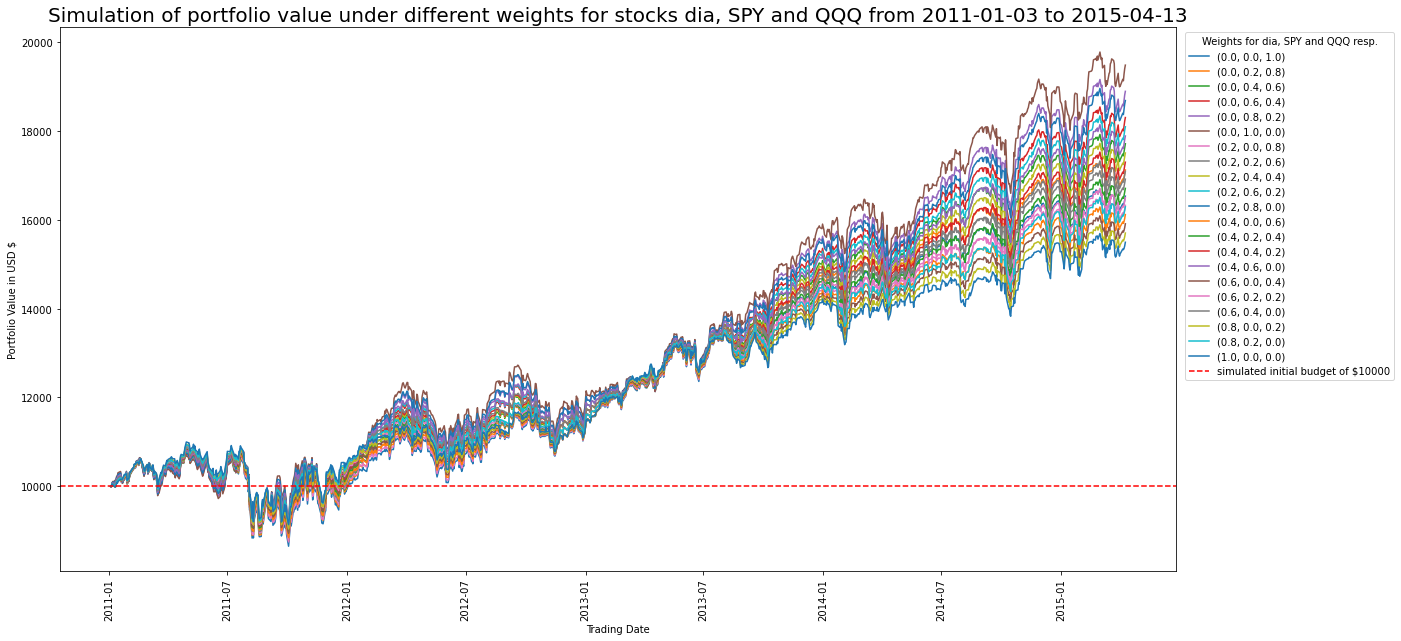

In [31]:
plt.figure(figsize=(20,10))

simulated_portfolio_values = []
for i in range(0,len(combinations)): 
    simulated_portfolio_values.append((combinations[i], simulate_portfolio_value(merged_df, combinations[i])['portfolio_value']))
simulated_portfolio_values

for i in range(0,len(simulated_portfolio_values)): 
    plt.plot(pd.to_datetime(simulated_portfolio_values[i][1].index), simulated_portfolio_values[i][1].values, label=str(simulated_portfolio_values[i][0]))
    
    
plt.axhline(y=10000, color='r',  ls='--', label=f'simulated initial budget of ${initial_budget}')

plt.legend(loc='upper right', title='Weights for dia, SPY and QQQ resp.', bbox_to_anchor=(1.2, 1.0))
plt.xticks(rotation=90)
plt.title(f"Simulation of portfolio value under different weights for stocks dia, SPY and QQQ from {start_dt} to {end_dt}", fontsize=20)
plt.xlabel("Trading Date")
plt.ylabel("Portfolio Value in USD $")



In [59]:
i = 0
simulated_portfolio_values_df_list = []

simulated_portfolio_values[i]

for i in range(0,len(simulated_portfolio_values)): 
    
    price_data =simulated_portfolio_values[i][1]
    returns = (price_data / price_data.shift(1)) - 1
    returns = returns.iloc[1:]
    VaR = rt.historical_var(returns, confidence_level=0.95)
    cVaR = rt.historical_cvar(returns, confidence_level=0.95)
    sharpe_ratio = fr.get_sharpe_ratio(returns, risk_free_rate=0.02)
    sortino_ratio = fr.get_sortino_ratio(returns, risk_free_rate=0.02)
    
    simulated_portfolio_values_df_list.append(pd.DataFrame({'portfolio_config':[str(simulated_portfolio_values[i][0])], \
                                                            'mean':[np.mean(simulated_portfolio_values[i][1])], \
                                                            'var':[np.var(simulated_portfolio_values[i][1])], \
                                                            'std':[np.std(simulated_portfolio_values[i][1])],\
                                                            'VaR':[VaR], 'cVaR':[cVaR], 'sharpe_ratio':[sharpe_ratio],\
                                                            'sortino_ratio':[sortino_ratio]
                                                           }))
    
simulated_portfolio_values_df = pd.concat(simulated_portfolio_values_df_list)
simulated_portfolio_values_df['net_return'] = (simulated_portfolio_values_df['mean']-initial_budget)/initial_budget
simulated_portfolio_values_df.reset_index().drop(columns='index').style.background_gradient()

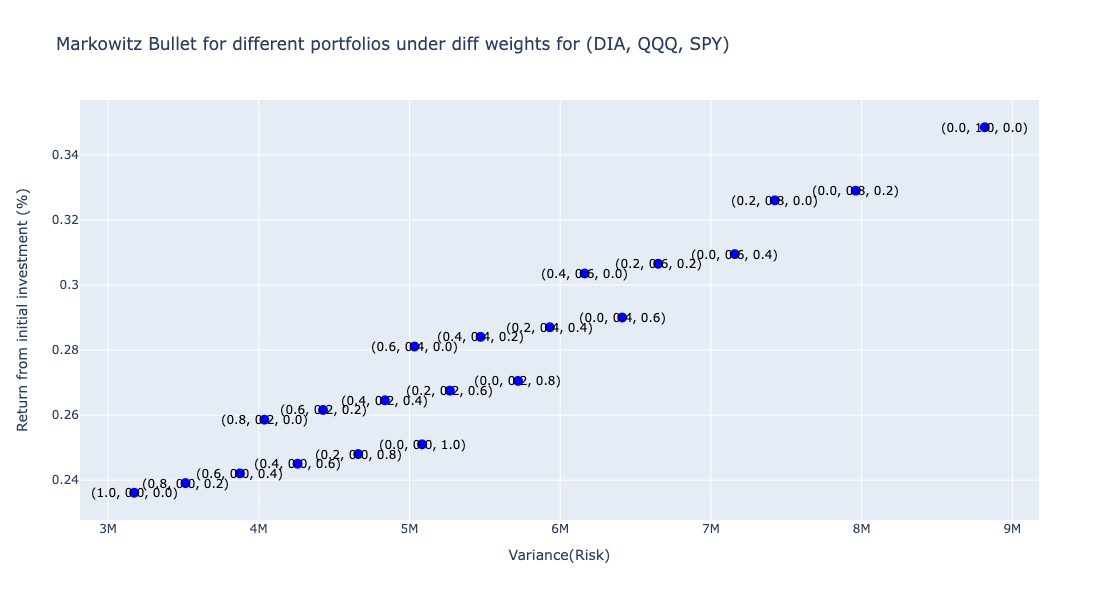

In [33]:
plot.plot_markowitz_bullet(list(simulated_portfolio_values_df['var']), list(simulated_portfolio_values_df['net_return']), \
                           text_vals =list(simulated_portfolio_values_df['portfolio_config']), \
                           title='Markowitz Bullet for different portfolios under diff weights for (DIA, QQQ, SPY)',\
                           xaxis_title='Variance(Risk)', yaxis_title='Return from initial investment (%)', height=600, width=800)



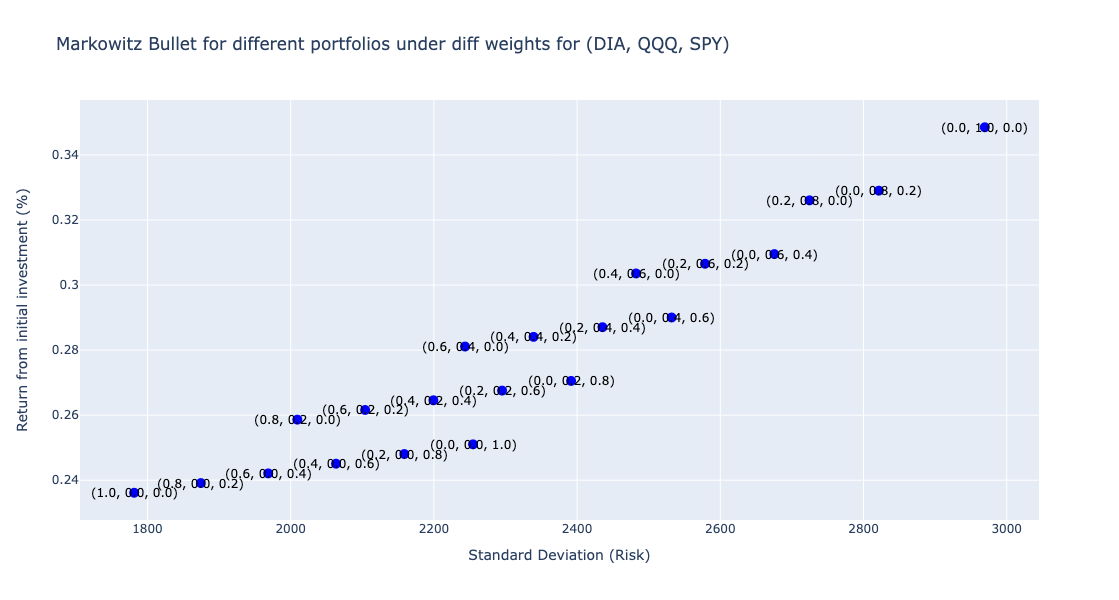

In [34]:
plot.plot_markowitz_bullet(list(simulated_portfolio_values_df['std']), list(simulated_portfolio_values_df['net_return']), \
                           text_vals =list(simulated_portfolio_values_df['portfolio_config']), \
                           title='Markowitz Bullet for different portfolios under diff weights for (DIA, QQQ, SPY)',\
                           xaxis_title='Standard Deviation (Risk)', yaxis_title='Return from initial investment (%)', height=600, width=800)

In [55]:

temp_df = simulated_portfolio_values_df[['portfolio_config', 'VaR']].copy(deep=True)
temp_df.reset_index(drop=True, inplace=True)
styled_df = temp_df.style.background_gradient(cmap='Blues')
styled_df


In [56]:

temp_df = simulated_portfolio_values_df[['portfolio_config', 'cVaR']].copy(deep=True)
temp_df.reset_index(drop=True, inplace=True)
styled_df = temp_df.style.background_gradient(cmap='Blues')
styled_df

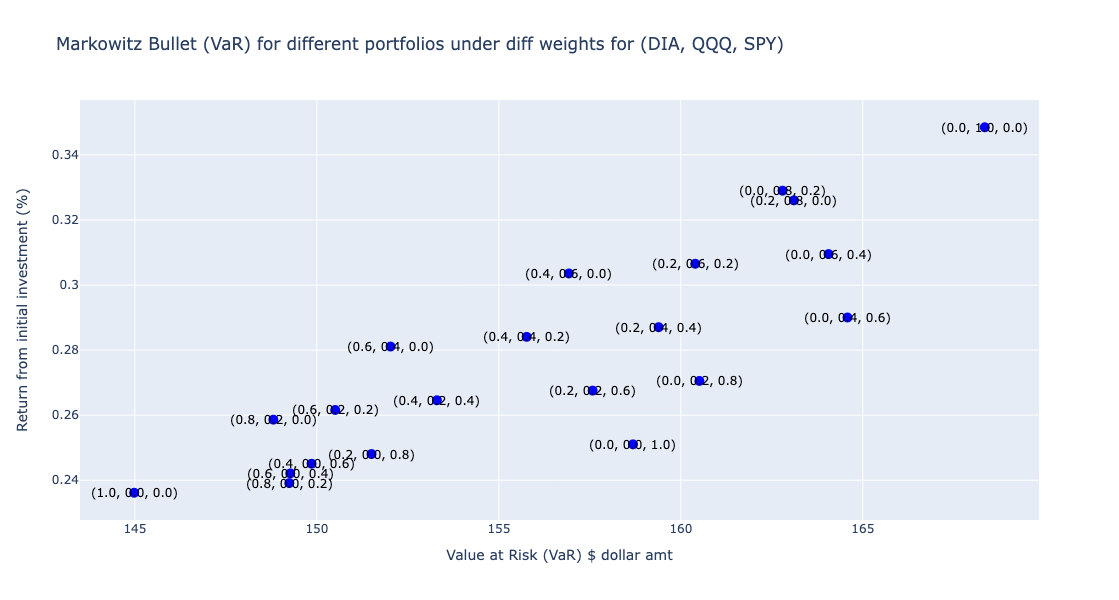

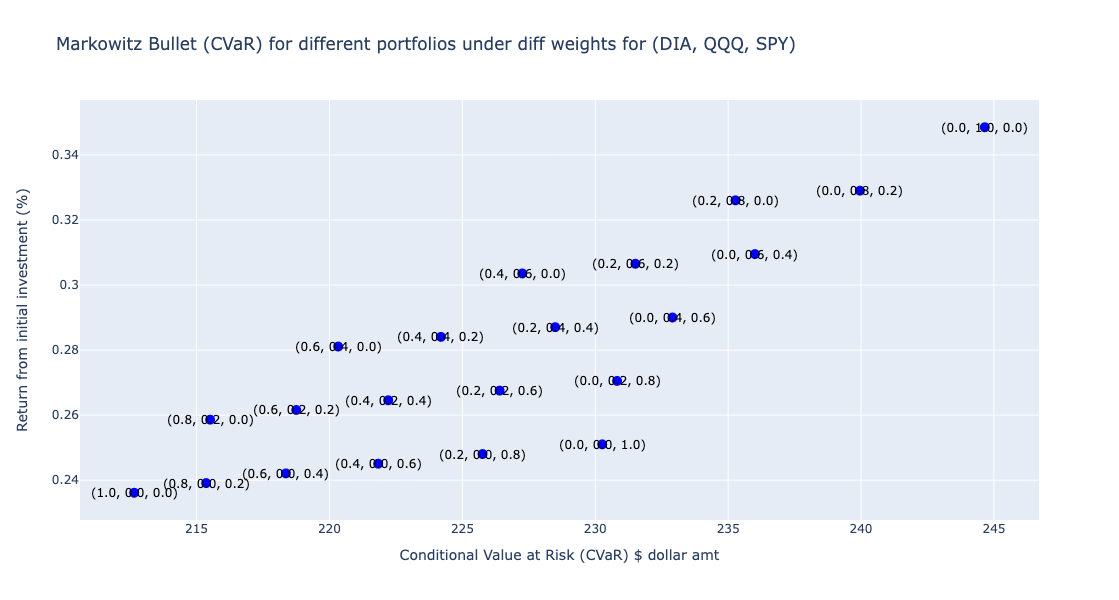

In [54]:
simulated_portfolio_values_df['VaR ($)'] = simulated_portfolio_values_df[['VaR']]*initial_budget
simulated_portfolio_values_df['cVaR ($)'] = simulated_portfolio_values_df[['cVaR']]*initial_budget

plot.plot_markowitz_bullet(list(simulated_portfolio_values_df['VaR ($)']), list(simulated_portfolio_values_df['net_return']), \
                           text_vals =list(simulated_portfolio_values_df['portfolio_config']), \
                           title='Markowitz Bullet (VaR) for different portfolios under diff weights for (DIA, QQQ, SPY)',\
                           xaxis_title=r'Value at Risk (VaR) $ dollar amt', yaxis_title='Return from initial investment (%)', height=600, width=800)

plot.plot_markowitz_bullet(list(simulated_portfolio_values_df['cVaR ($)']), list(simulated_portfolio_values_df['net_return']), \
                           text_vals =list(simulated_portfolio_values_df['portfolio_config']), \
                           title='Markowitz Bullet (CVaR) for different portfolios under diff weights for (DIA, QQQ, SPY)',\
                           xaxis_title=r'Conditional Value at Risk (CVaR) $ dollar amt', yaxis_title='Return from initial investment (%)', height=600, width=800)

# Portfolio Evaluation and Comparison using Financial Ratios 

### Sharpe Ratios

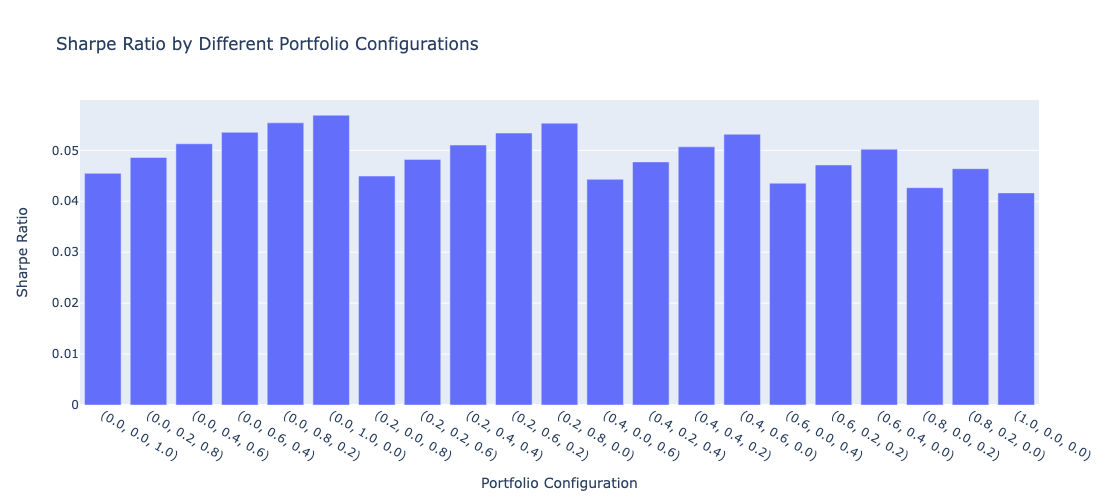

In [40]:
plot.create_barplot(simulated_portfolio_values_df['portfolio_config'], simulated_portfolio_values_df['sharpe_ratio'], \
               title='Sharpe Ratio by Different Portfolio Configurations', x_title='Portfolio Configuration', y_title='Sharpe Ratio')

In [41]:
temp_df = simulated_portfolio_values_df[['portfolio_config', 'sharpe_ratio']].copy(deep=True)
temp_df.reset_index(drop=True, inplace=True)
styled_df = temp_df.style.background_gradient(cmap='Blues')
styled_df

### Sortino Ratios

In [42]:
temp_df = simulated_portfolio_values_df[['portfolio_config', 'sortino_ratio']].copy(deep=True)
temp_df.reset_index(drop=True, inplace=True)
styled_df = temp_df.style.background_gradient(cmap='Blues')
styled_df

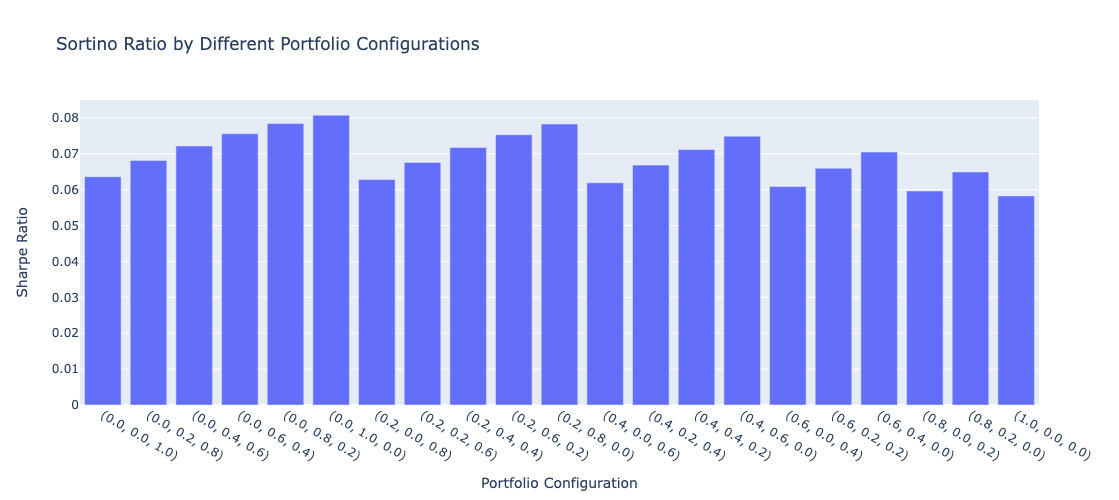

In [43]:


plot.create_barplot(simulated_portfolio_values_df['portfolio_config'], simulated_portfolio_values_df['sortino_ratio'], \
               title='Sortino Ratio by Different Portfolio Configurations', x_title='Portfolio Configuration', y_title='Sharpe Ratio')

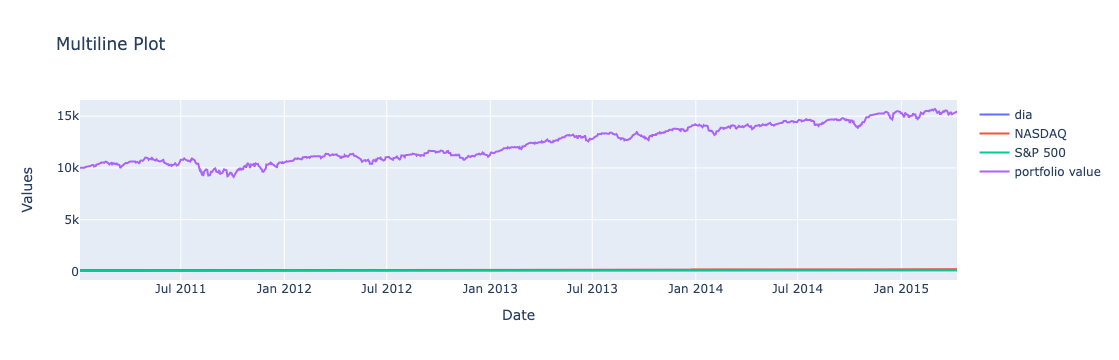

In [44]:

columns_to_plot = ['Close_DIA', 'Close_SPY', 'Close_QQQ', 'portfolio_value']
labels = ['dia',  'NASDAQ', 'S&P 500','portfolio value']

fig = plot.multiline_plot(merged_df, columns_to_plot, labels)
fig.show()


### Forecasting Using Facebook Prophet

In [45]:
!pip install prophet

Looking in indexes: https://artifacts-prod-use1.pinadmin.com/artifactory/api/pypi/pinterest-python-pip-prod-virtual/simple/


15:41:50 - cmdstanpy - INFO - Chain [1] start processing
15:41:51 - cmdstanpy - INFO - Chain [1] done processing


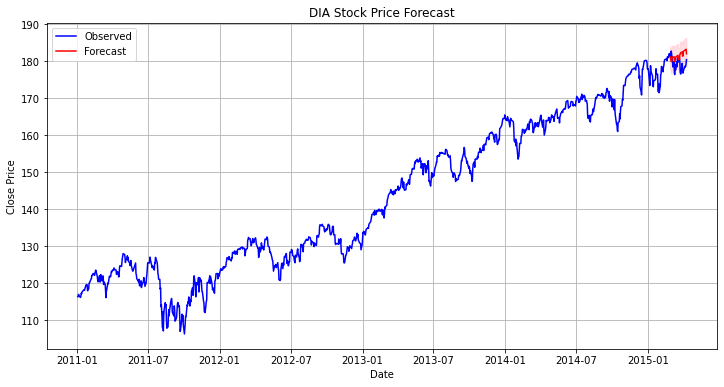

In [46]:
ph.plot_prediction(dia_df, ticker='DIA', test_period=30)

15:41:51 - cmdstanpy - INFO - Chain [1] start processing
15:41:51 - cmdstanpy - INFO - Chain [1] done processing


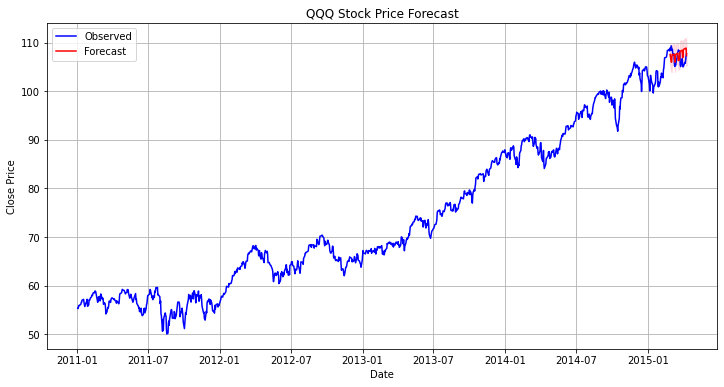

In [47]:
ph.plot_prediction(qqq_df, ticker='QQQ', test_period=30)

15:41:52 - cmdstanpy - INFO - Chain [1] start processing
15:41:52 - cmdstanpy - INFO - Chain [1] done processing


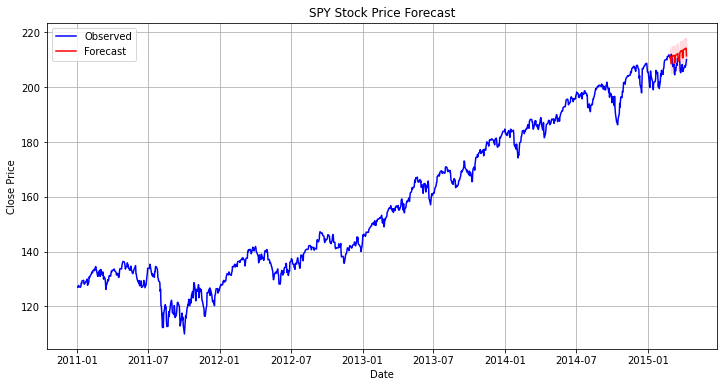

In [48]:
ph.plot_prediction(spy_df, ticker='SPY', test_period=30)

### Optimal Portfolio Weights over Time 

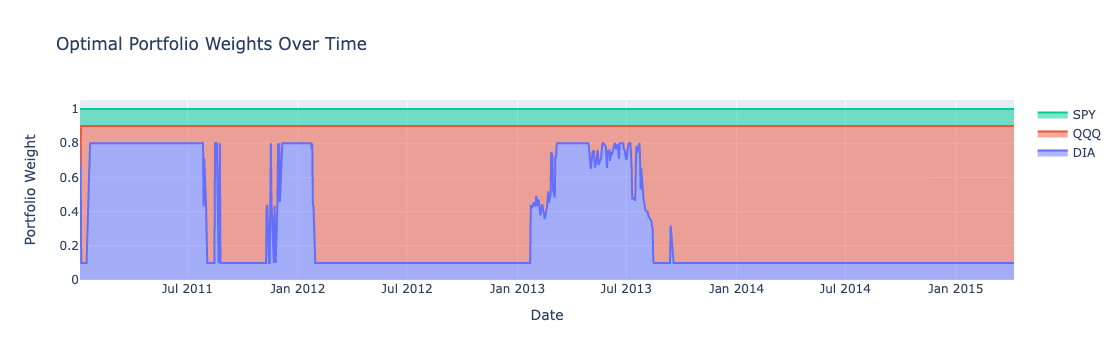

In [49]:
min_weight = 0.1
max_weight = 0.9

# Annual risk-free rate
annual_risk_free_rate = 0.02
# Convert annual risk-free rate to daily rate
daily_risk_free_rate = (1 + annual_risk_free_rate) ** (1/252) - 1


# Calculate mean returns and covariance matrix
cov_matrix = np.cov(returns)


unique_dates = list(set(merged_df.index))
unique_dates.sort()
unique_dates



moving_optimal_weights = []

for N in range(2,len(unique_dates)): 
    DIA = list(dia_df.ticker_data['pct_change'].iloc[1:N])
    QQQ = list(qqq_df.ticker_data['pct_change'].iloc[1:N])
    SPY = list(spy_df.ticker_data['pct_change'].iloc[1:N])

    # Calculate mean returns and covariance matrix

    returns = np.array([DIA, QQQ, SPY])
    mean_returns = np.mean(returns, axis=1)

    cov_matrix = np.cov(returns)

    # Set target return
    target_return = 0.02
       
    # Perform optimization
    num_stocks = len(mean_returns)
    optimal_weights = opt.maximize_sharpe_ratio(mean_returns, cov_matrix, daily_risk_free_rate, num_stocks, min_weight, max_weight)


    moving_optimal_weights.append(optimal_weights.x)

area_plot = plot.create_area_plot(moving_optimal_weights, tickers, unique_dates)
area_plot.show()

